# CNN model za binarnu klasifikaciju
U nastavku se nalazi projekat koji za cilj ima kreiranje konvolutivne neuralne mreže u cilju binarne klasifikacije. 
Za ulazni dataset se koristi [dataset sa Kaggle repozitorijuma](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) Chest X-Ray Images (Pneumonia), koji sadrži fotografije rendgena grudnog koša koji su podeljeni na primere zdravih pacijenata i pacijenata sa upalom pluća, gde je cilj dobiti model koji će na novoj instanci predvideti da li je nova ulazna fotografija rendgena grudnog koša zdravog pacijenta ili sa pneumonijom. 

#### Učitavanje potrebnih biblioteka

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import random
import shutil
import os
tf.random.set_seed(22)

#### Analiza ulaznog skupa
Ulazni skup podataka podeljen u tri direktorijuma - train, validation i test, a svaki od njih ima i pod-direktorijum PNEUMONIA i NORMAL odnosno target varijabla. Kao prvi korak potrebno je analizirati ulazni skup, tako da dobijemo informacije o broju instanci za svaki od podskupova. 

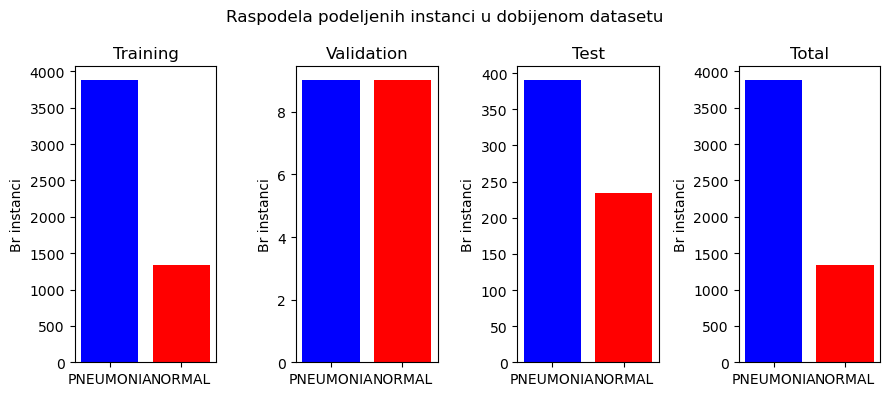

In [2]:
train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'
test_dir = 'chest_xray/test'

broj_train = {}
for subdir in os.listdir(train_dir):
    subdir_path = os.path.join(train_dir, subdir)
    if os.path.isdir(subdir_path):
        broj_train[subdir] = len(os.listdir(subdir_path))

broj_val = {}
for subdir in os.listdir(val_dir):
    subdir_path = os.path.join(val_dir, subdir)
    if os.path.isdir(subdir_path):
        broj_val[subdir] = len(os.listdir(subdir_path))

broj_test = {}
for subdir in os.listdir(test_dir):
    subdir_path = os.path.join(test_dir, subdir)
    if os.path.isdir(subdir_path):
        broj_test[subdir] = len(os.listdir(subdir_path))
        
total = broj_test.copy() | broj_val.copy() | broj_train.copy()

fig, axes = plt.subplots(1, 4, figsize= (9, 4))

axes[0].bar(broj_train.keys(), broj_train.values(), color=['blue', 'red'])
axes[0].set_ylabel('Br instanci')
axes[0].set_title('Training')

axes[1].bar(broj_val.keys(), broj_val.values(), color=['blue', 'red'])
axes[1].set_ylabel('Br instanci')
axes[1].set_title('Validation')

# Plot the bar chart for test set
axes[2].bar(broj_test.keys(), broj_test.values(), color=['blue', 'red'])
axes[2].set_ylabel('Br instanci')
axes[2].set_title('Test')

axes[3].bar(total.keys(), total.values(), color=['blue', 'red'])
axes[3].set_ylabel('Br instanci')
axes[3].set_title('Total')



# Adjust layout
plt.suptitle('Raspodela podeljenih instanci u dobijenom datasetu')
plt.tight_layout()

plt.show()


Na osnovu dobijenog grafika se može zaključiti da je dataset nebalansiran, odnosno da sadrži značajno više instanci PNEUMONIA u odnosu na NORMAL. Takođe, nije jasna procentualna podela podataka ukupnog skupa na validation i test deo, te se u nastavku kreira novi dataset koji train:validation:test deli u odnosu 80:10:10 i prikazuje njihov odnos na bar chart-u. 

In [3]:
dataset_path= 'chest_xray/'
novi_dataset_path = 'chest_xray_new/'
if not os.path.exists(novi_dataset_path):
   for tip in ['train', 'val', 'test']:
       for kategorija in ['NORMAL', 'PNEUMONIA']:
           os.makedirs(f'{novi_dataset_path}/{tip}/{kategorija}', exist_ok=True)

   for kategorija in ['NORMAL', 'PNEUMONIA']:
       all_files = []
       for tip in ['train', 'val', 'test']:
           source_folder = f'{dataset_path}/{tip}/{kategorija}'
           files = os.listdir(source_folder)
           all_files.extend([(file, source_folder) for file in files])

       random.shuffle(all_files)
       #80:10:10 
       train_files = all_files[:int(len(all_files)*0.8)]
       val_files = all_files[int(len(all_files)*0.8):int(len(all_files)*0.9)]
       test_files = all_files[int(len(all_files)*0.9):]

       for file, source_folder in train_files:
           dest = f'{novi_dataset_path}/train/{kategorija}/{file}'
           shutil.copy(f'{source_folder}/{file}', dest)

       for file, source_folder in val_files:
           dest = f'{novi_dataset_path}/val/{kategorija}/{file}'
           shutil.copy(f'{source_folder}/{file}', dest)

       for file, source_folder in test_files:
           dest = f'{novi_dataset_path}/test/{kategorija}/{file}'
           shutil.copy(f'{source_folder}/{file}', dest)  


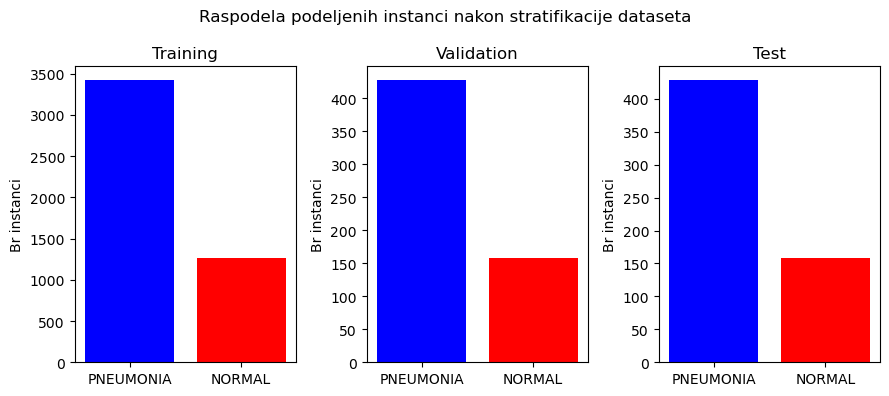

In [4]:
train_dir = 'chest_xray_new/train'
val_dir = 'chest_xray_new/val'
test_dir = 'chest_xray_new/test'

broj_train = {}
for subdir in os.listdir(train_dir):
    subdir_path = os.path.join(train_dir, subdir)
    if os.path.isdir(subdir_path):
        broj_train[subdir] = len(os.listdir(subdir_path))

broj_val = {}
for subdir in os.listdir(val_dir):
    subdir_path = os.path.join(val_dir, subdir)
    if os.path.isdir(subdir_path):
        broj_val[subdir] = len(os.listdir(subdir_path))

broj_test = {}
for subdir in os.listdir(test_dir):
    subdir_path = os.path.join(test_dir, subdir)
    if os.path.isdir(subdir_path):
        broj_test[subdir] = len(os.listdir(subdir_path))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize= (9, 4))

axes[0].bar(broj_train.keys(), broj_train.values(), color=['blue', 'red'])
axes[0].set_ylabel('Br instanci')
axes[0].set_title('Training')

axes[1].bar(broj_val.keys(), broj_val.values(), color=['blue', 'red'])
axes[1].set_ylabel('Br instanci')
axes[1].set_title('Validation')

# Plot the bar chart for test set
axes[2].bar(broj_test.keys(), broj_test.values(), color=['blue', 'red'])
axes[2].set_ylabel('Br instanci')
axes[2].set_title('Test')

# Adjust layout
plt.suptitle('Raspodela podeljenih instanci nakon stratifikacije dataseta')
plt.tight_layout()

plt.show()


Radi efikasnosti, rezoluciju slika ćemo podesiti da bude 240x240px, a za batchsize ćemo postaviti 32. 

In [5]:
img_h = 240
img_w = 240
batch_size = 32

Obzirom na to da će u ovom delu biti korišćena Keras biblioteka, koristićemo bibliotečku podršku za definisanje datasetova. 

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, 
    color_mode = 'grayscale',
    image_size = (img_h, img_w),
    batch_size = batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir, 
    color_mode = 'grayscale',
    image_size = (img_h, img_w),
    batch_size = batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, 
    color_mode = 'grayscale',
    image_size = (img_h, img_w),
    batch_size = batch_size
)



Found 4684 files belonging to 2 classes.
Found 585 files belonging to 2 classes.
Found 587 files belonging to 2 classes.


2024-07-31 21:22:42.876607: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-07-31 21:22:42.876625: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-31 21:22:42.876632: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-31 21:22:42.876645: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-31 21:22:42.876655: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
train_ds.class_names

['NORMAL', 'PNEUMONIA']

U nastavku ćemo prikazati 9 primera fotografija rendgena grudnog koša iz dataseta, zajedno sa njihovim oznakama. 

2024-07-31 21:22:43.288305: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


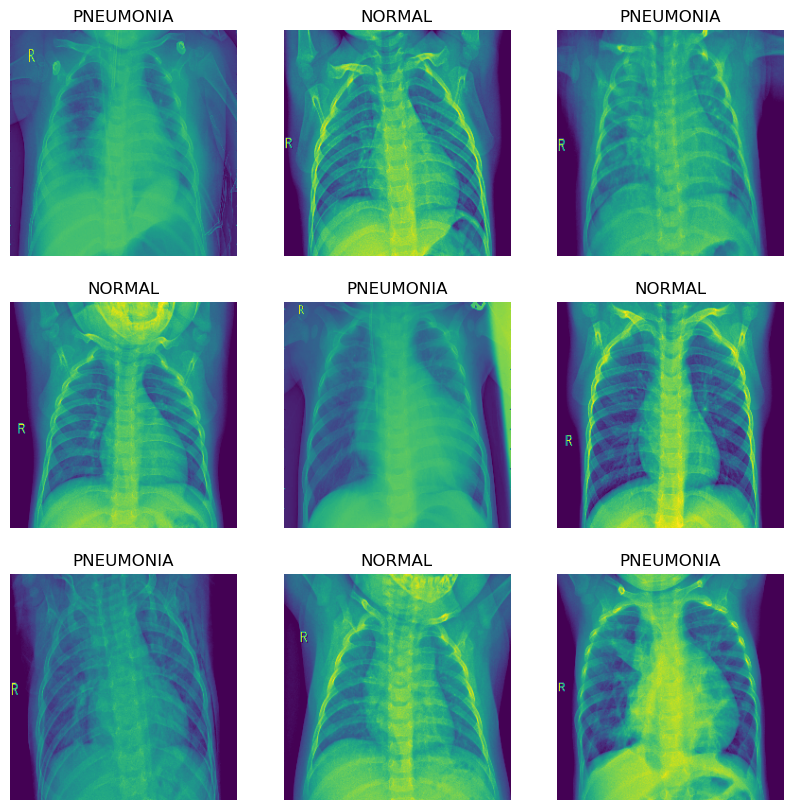

In [8]:
plt.figure(figsize=(10, 10))
for slike, oznake in train_ds.take(1): 
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(np.squeeze(slike[i].numpy().astype("uint8")))
        plt.title(train_ds.class_names[oznake[i]]) 
        plt.axis("off")                  

Radi optimizacije modela, koristićemo automatsku alokaciju dostupne lokalne memorije za optimalnije korišćenje dataseta u epohama. 

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

I pristupamo definisanju modela. 
---
- Na početku ćemo kreirati sloj koji normalizuje vrednost piksela, koji može imati vrednost od 0-255 (2^8), obzirom na to da je reč o crno-beloj slici, tako da vrednosti budu na skali od 0 do 1.
- Nakon toga postavljamo tri skrivena sloja koji koriste ReLU aktivacionu funkciju. Prvi ima 32 filtera veličine 3x3, naredni ima 64 i nakon njega 128 filtera. Nakon svakog konvolucionog sloja postavlja se i MaxPooling sloj koji smanjuje dimenziju izlaza prethodnog konvolucionog sloja za polovinu, koristeći maksimalnu vrednost u svakom regionu, odnosno u svakom 2x2 regionu što je default vrednost. 
- Nakon ovoga imamo kreiramo dva potpuno povezana sloja, koje prethodno izravnjujemo sa Flatten slojem, koristeći sa ReLU aktivacionom funkciju i L2 regularizacijom, Dropout radi regularizacije i izlazni sloj sa sigmoidnom aktivacionom funkcijom. 

In [10]:
model = tf.keras.Sequential([
    
    layers.Rescaling(scale=1./255), 
    
    layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01) ),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
    
    
])

Zatim model kompajliramo sa Adam optimajzerom, binarnom krosentropijom za funkciju gubitka i accuracy za metriku i fitujemo model. 

In [11]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

U prvom modelu ćemo postaviti broj epoha na 20

In [12]:
epochs = 20

In [13]:
model.fit(
    train_ds, 
    validation_data = val_ds,
    epochs = epochs, 
    verbose = 1
)


Epoch 1/20


2024-07-31 21:22:44.219216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


147/147 ━━━━━━━━━━━━━━━━━━━━ 34s 218ms/step - accuracy: 0.7227 - loss: 2.2045 - val_accuracy: 0.9299 - val_loss: 0.5871
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 30s 204ms/step - accuracy: 0.8769 - loss: 0.6068 - val_accuracy: 0.9436 - val_loss: 0.4455
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 30s 202ms/step - accuracy: 0.8921 - loss: 0.4797 - val_accuracy: 0.9487 - val_loss: 0.3405
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 29s 198ms/step - accuracy: 0.8982 - loss: 0.4039 - val_accuracy: 0.9402 - val_loss: 0.3555
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 29s 198ms/step - accuracy: 0.8966 - loss: 0.3938 - val_accuracy: 0.9145 - val_loss: 0.3360
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 29s 198ms/step - accuracy: 0.9028 - loss: 0.3731 - val_accuracy: 0.9214 - val_loss: 0.3121
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 29s 199ms/step - accuracy: 0.9102 - loss: 0.3602 - val_accuracy: 0.9282 - val_loss: 0.3026
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 32s 218ms/step - accuracy: 0.9083 - loss: 0.3682 - val

Izvlačimo i plotujemo loss i accuracy vrednosti po epohama.

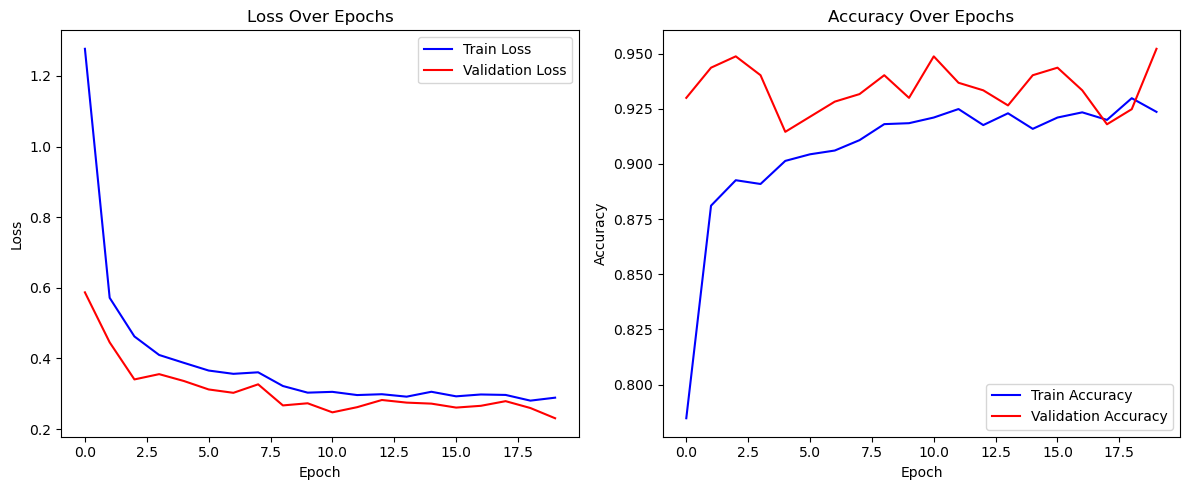

In [14]:
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
train_accuracy = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Na osnovu datih grafika dolazimo do zaključka da nije došlo do overfitovanja, kako se vrednosti relativno prate tokom epoha. Takođe, nakon 15. epohe nema poboljšanja u rezultatima modela. 

Izračunavanje tačnosti i gubitka na test datasetu

In [15]:
model.evaluate(test_ds)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9495 - loss: 0.2408


[0.24697405099868774, 0.9403747916221619]

Iscrtavanje confusion matrice za test dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


2024-07-31 21:36:38.179861: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


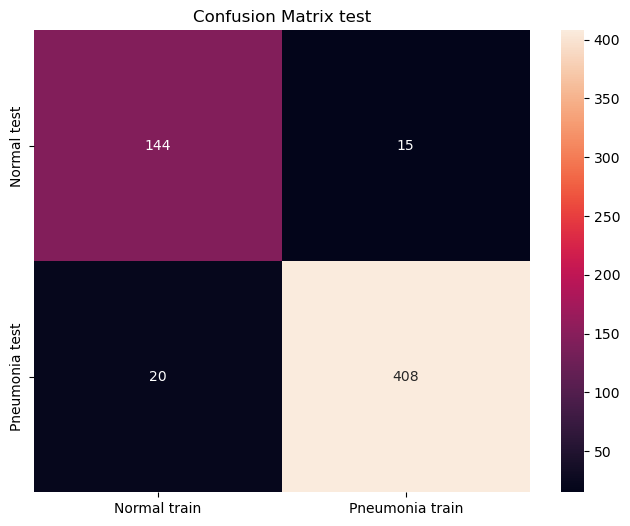

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

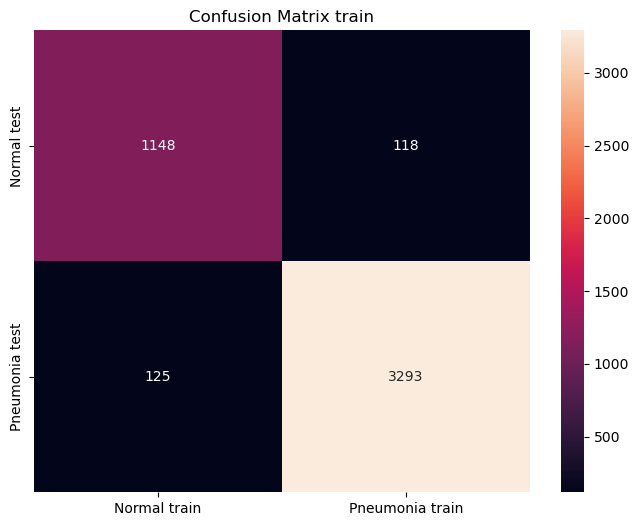

In [16]:

import seaborn as sns
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.round(predictions).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = tf.math.confusion_matrix(y_true, y_pred).numpy()

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Normal train', 'Pneumonia train'], yticklabels=['Normal test', 'Pneumonia test'])
plt.title('Confusion Matrix test')
plt.show()

y_true = []
y_pred = []

for images, labels in train_ds:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.round(predictions).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = tf.math.confusion_matrix(y_true, y_pred).numpy()

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Normal train', 'Pneumonia train'], yticklabels=['Normal test', 'Pneumonia test'])
plt.title('Confusion Matrix train')
plt.show()


### Definisanje drugog modela i upoređivanje rezultata

In [17]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
input_shape = (240, 240, 3)
def preprocess_image(image):
    return tf.image.grayscale_to_rgb(image)

In [19]:
train_ds_rgb = train_ds.map(lambda x, y: (preprocess_image(x), y))
val_ds_rgb = val_ds.map(lambda x, y: (preprocess_image(x), y))
test_ds_rgb = test_ds.map(lambda x, y: (preprocess_image(x), y))

In [20]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False

inputs = Input(shape=(img_h, img_w, 3))
x = base_model(inputs, training=False)
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
model_vgg16 = Model(inputs, outputs)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [24]:
model_vgg16.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [25]:
epochs = 20
history_vgg16 = model_vgg16.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,
    epochs=epochs,
    verbose=1
)

Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 82s 547ms/step - accuracy: 0.8757 - loss: 9.2200 - val_accuracy: 0.9624 - val_loss: 1.5979
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 133s 909ms/step - accuracy: 0.9505 - loss: 1.4203 - val_accuracy: 0.9521 - val_loss: 1.0542
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.9552 - loss: 0.9574 - val_accuracy: 0.9504 - val_loss: 0.8694
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 143s 975ms/step - accuracy: 0.9521 - loss: 0.7599 - val_accuracy: 0.9641 - val_loss: 0.6399
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.9189 - loss: 0.6641 - val_accuracy: 0.9624 - val_loss: 0.5153
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.9459 - loss: 0.5389 - val_accuracy: 0.9538 - val_loss: 0.5065
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.9257 - loss: 0.4935 - val_accuracy: 0.9521 - val_loss: 0.4993
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.9235 - loss: 0.4491 - 

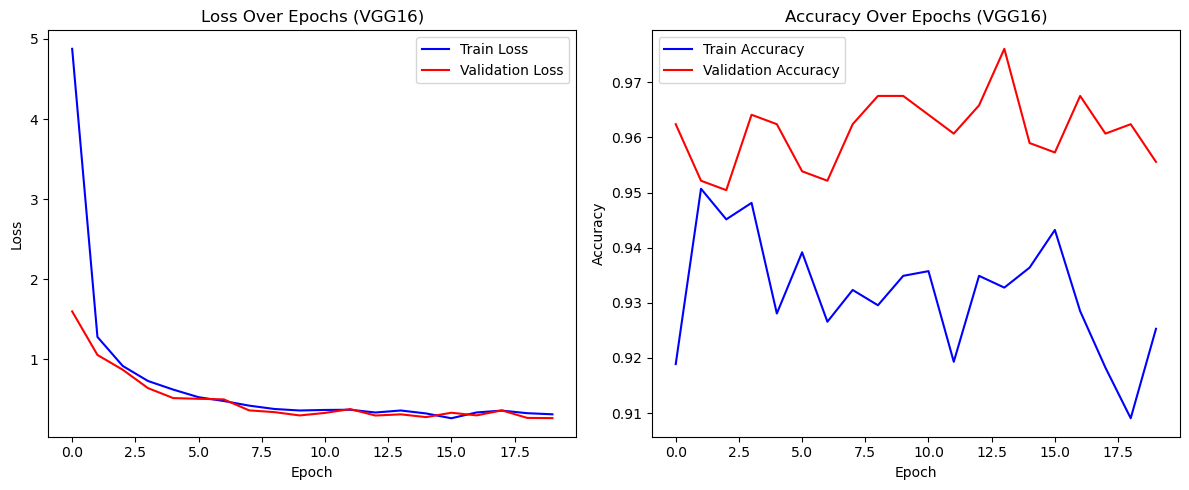

19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 752ms/step - accuracy: 0.9373 - loss: 0.2724
Test Loss (VGG16): 0.2753782272338867
Test Accuracy (VGG16): 0.9386712312698364
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


2024-07-31 22:55:06.630253: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


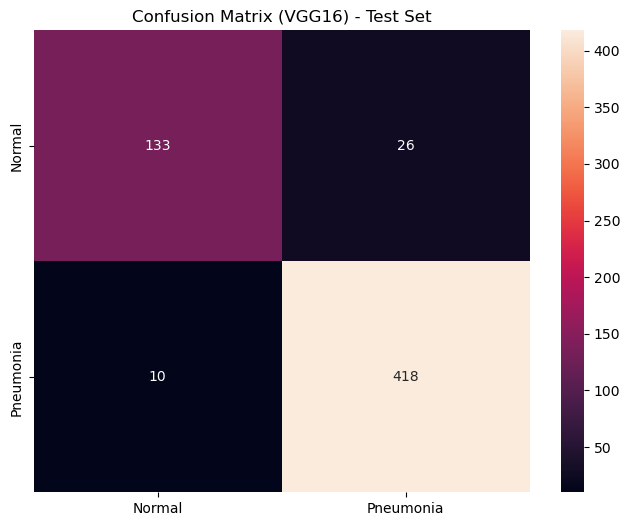

In [26]:
# Vizualizacija rezultata
train_loss_vgg16 = history_vgg16.history['loss']
val_loss_vgg16 = history_vgg16.history['val_loss']
train_accuracy_vgg16 = history_vgg16.history['accuracy']
val_accuracy_vgg16 = history_vgg16.history['val_accuracy']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_vgg16, label='Train Loss', color='blue')
plt.plot(val_loss_vgg16, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs (VGG16)')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_vgg16, label='Train Accuracy', color='blue')
plt.plot(val_accuracy_vgg16, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs (VGG16)')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluacija na test skupu
test_loss_vgg16, test_accuracy_vgg16 = model_vgg16.evaluate(test_ds_rgb)

print(f'Test Loss (VGG16): {test_loss_vgg16}')
print(f'Test Accuracy (VGG16): {test_accuracy_vgg16}')

# Konfuziona matrica za test skup
y_true = []
y_pred = []

for images, labels in test_ds_rgb:
    y_true.extend(labels.numpy())
    predictions = model_vgg16.predict(images)
    y_pred.extend(np.round(predictions).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm_vgg16 = tf.math.confusion_matrix(y_true, y_pred).numpy()

plt.figure(figsize=(8, 6))
sns.heatmap(cm_vgg16, annot=True, fmt='d', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix (VGG16) - Test Set')
plt.show()